# Push Notificactions No lineal models 
Predictive model: People interested in a product.  
Given a user and a product, predict if the wuold buy it if theywere buying at that moment.  
user with basket > 5 products  
No linear models

## DataSet and functions

In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.figure
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score

pd.options.display.max_columns = None
pd.options.display.max_rows = 10

### Functions

In [2]:
def plot_metrics(
    model_name: str,
    y_pred: pd.Series,
    y_test: pd.Series,
    figure: tuple[matplotlib.figure.Figure, np.array] = None,
):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    else:
        fig, ax = figure

    ax[0].plot(recall, precision, label=f"{model_name}: AUC:{pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title(f"precision-recall Curve")
    ax[0].legend()

    ax[1].plot(fpr, tpr, label=f"{model_name} - AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title(f"ROC Curve")
    ax[1].legend()

In [184]:
def Standardization(x_train: pd.DataFrame):
    scaler = StandardScaler()
    x_train_columns = x_train.columns
    x_train = scaler.fit_transform(x_train)
    x_train = pd.DataFrame(x_train, columns=x_train_columns)
    return x_train

In [185]:
def slip_data_set(df: pd.DataFrame, y: pd.Series):
    x_train = df.iloc[: int(len(df) * 0.7)]
    x_test = df.iloc[int(len(df) * 0.7) : int(len(df) * 0.9)]
    x_valid = df.iloc[int(len(df) * 0.9) :]

    y_train = y.iloc[: int(len(y) * 0.7)]
    y_test = y.iloc[int(len(y) * 0.7) : int(len(y) * 0.9)]
    y_valid = y.iloc[int(len(y) * 0.9) :]

    x_train = Standardization(x_train)
    return x_train, x_test, x_valid, y_train, y_test, y_valid

In [186]:
def evaluate_model(
    name: str,
    model: object,  # sklearn.model
    x_train: pd.DataFrame,
    y_train: pd.DataFrame,
    x_test: pd.Series,
    y_test: pd.Series,
):
    y_train_predic = model.predict_proba(x_train)[:, 1]
    y_test_predic = model.predict_proba(x_test)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_predic)
    test_auc = roc_auc_score(y_test, y_test_predic)

    train_cross = log_loss(y_train, y_train_predic)
    test_cross = log_loss(y_test, y_test_predic)

    train_precision = average_precision_score(y_train, y_train_predic)
    test_precision = average_precision_score(y_test, y_test_predic)

    print(f"{name}:")
    print(
        f"Train_auc:{train_auc:.3f}, Train_precision: {train_precision:.3f}, Train_cross:{train_cross:.3f}"
    )
    print(
        f"Test_auc:{test_auc:.3f}, Test_precision: {test_precision:.3f}, Test_cross:{test_cross:.3f}"
    )

### Load the data

In [6]:
folder_path = Path(
    "D:/Users/maick/Desktop/Codigos/zrive-ds/data/box_builder_dataset/feature_frame.csv"
)
feature_frame = pd.read_csv(folder_path)

## Preparation of the dataset

Filter for >5 products

In [ ]:
size_of_order = feature_frame.groupby("order_id").outcome.sum()
size_of_order = size_of_order[size_of_order >= 5]
feature_frame = feature_frame[feature_frame["order_id"].isin(size_of_order.index)]
feature_frame.shape[0]

2163953

Setting Dates cutoff

The 70% of orders were before the 2021-02-04
The 90% of orders were before the 2021-02-22


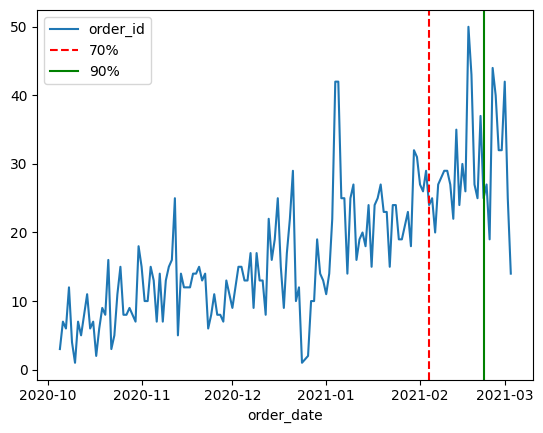

In [8]:
feature_frame["order_date"] = pd.to_datetime(feature_frame["order_date"]).dt.date

orders_diary = feature_frame.groupby("order_date").order_id.nunique()
porcentaje_orders_dairy = orders_diary.cumsum() / orders_diary.sum()

train_val_cutoff = porcentaje_orders_dairy[porcentaje_orders_dairy <= 0.7].idxmax()
val_test_cutoff = porcentaje_orders_dairy[porcentaje_orders_dairy <= 0.9].idxmax()

print(f"The 70% of orders were before the {train_val_cutoff}")
print(f"The 90% of orders were before the {val_test_cutoff}")
orders_diary.plot(kind="line")
plt.axvline(
    x=pd.to_datetime(train_val_cutoff), color="red", linestyle="--", label="70%"
)
plt.axvline(
    x=pd.to_datetime(val_test_cutoff), color="green", linestyle="-", label="90%"
)
plt.legend()

Sort the dataset

In [9]:
feature_frame = (
    feature_frame.sort_values("order_date", ascending=True).reset_index()
).drop("index", axis=1)

### Columns no numeric

Delete columns and Separate the data numeric

In [10]:
feature_frame = feature_frame.drop("variant_id", axis=1)
feature_frame = feature_frame.drop("user_id", axis=1)
feature_frame = feature_frame.drop("created_at", axis=1)
feature_frame = feature_frame.drop("order_id", axis=1)

column_numerics = []
for columns in feature_frame.dtypes:
    if columns == "int64" or columns == "float64":
        column_numerics.append(True)
    else:
        column_numerics.append(False)

feature_frame_numeric = feature_frame.loc[:, column_numerics]
feature_frame_numeric

,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,4,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
2,2,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
3,3,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
4,3,0.0,0.0,0.0,0.0,0.0,0.067498,0.160643,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,30.498299,30.0,32.0,25.841947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163948,2,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,30.0,30.0,26.081884
2163949,7,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,40.0,30.0,26.081884
2163950,4,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,30.0,30.0,26.081884
2163951,4,0.0,0.0,0.0,0.0,0.0,0.034969,0.155039,0.000714,2.0,0.0,0.0,0.0,2.0,33.0,51.0,20.825465,30.0,30.0,18.973072


## Divide the dataset

In [11]:
y = feature_frame_numeric["outcome"]
x = feature_frame_numeric.drop(columns=["outcome"])

The three vatiables withmore importance

In [ ]:
xf = x[["ordered_before", "global_popularity", "abandoned_before"]]

x_train_3, x_test_3, x_valid_3, y_train, y_test, y_valid = slip_data_set(
    xf, feature_frame_numeric["outcome"]
)

Train: 1514767 and 1514767 
Valid: 432790 and 216396
Test: 216396 and 432790


## Baseline

In [173]:
baseline_predictions = (feature_frame["global_popularity"] >= 0.5).astype(int)

## LogisticRegression

In [ ]:
# Rigde
LogReg_model_rigde_f = LogisticRegression(
    penalty="l2",
    solver="liblinear",
)

LogReg_model_rigde_f.fit(x_train_3, y_train)

In [175]:
y_train_LogReg_model_rigde_f = LogReg_model_rigde_f.predict(x_train_3)
y_test_LogReg_model_rigde_f = LogReg_model_rigde_f.predict(x_test_3)

evaluate_model(
    name=f"LogReg_model_rigde_f",
    model=LogReg_model_rigde_f,
    x_train=x_train_3,
    y_train=y_train,
    x_test=x_test_3,
    y_test=y_test,
)

LogReg_model_rigde_f:
Train_auc:0.833, Train_precision: 0.156, Train_cross:0.067
Test_auc:0.834, Test_precision: 0.155, Test_cross:0.070


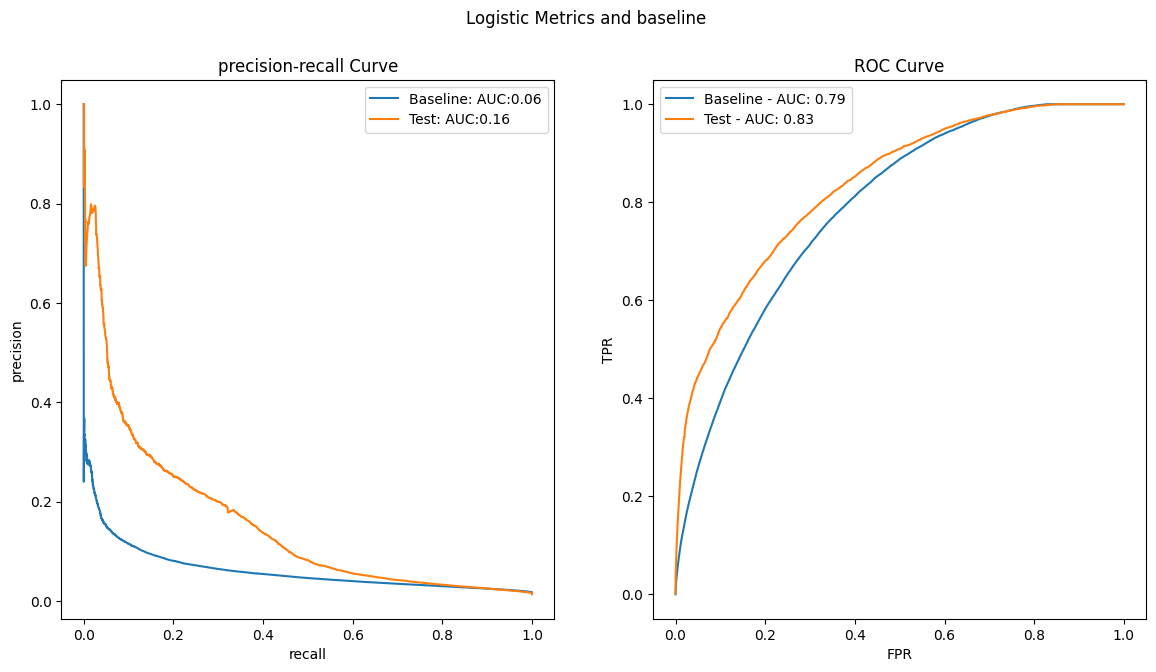

In [176]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Logistic Metrics and baseline")

plot_metrics(
    f"Baseline",
    y_pred=feature_frame["global_popularity"],
    y_test=feature_frame["outcome"],
    figure=(fig1, ax1),
)

y_test_proba_LogReg_model_rigde_f = LogReg_model_rigde_f.predict_proba(x_test_3)[:, 1]
plot_metrics(
    f"Test", y_pred=y_test_proba_LogReg_model_rigde_f, y_test=y_test, figure=(fig1, ax1)
)

# Random Forest

In [ ]:
x_train_all, x_test_all, x_valid_all, y_train, y_test, y_valid = slip_data_set(
    x, feature_frame_numeric["outcome"]
)

Train: 1514767 and 1514767 
Valid: 432790 and 432790
Test: 216396 and 216396


RamdomForest with all dataset

In [ ]:
randomforest_model_dataset_normal = RandomForestClassifier(
    class_weight="balanced",
    n_estimators=100,
)
randomforest_model_dataset_normal = randomforest_model_dataset_normal.fit(
    x_train_all, y_train
)

Random Forest:
Train_auc:0.989, Train_precision: 0.518, Train_cross:0.039
Test_auc:0.512, Test_precision: 0.014, Test_cross:0.468


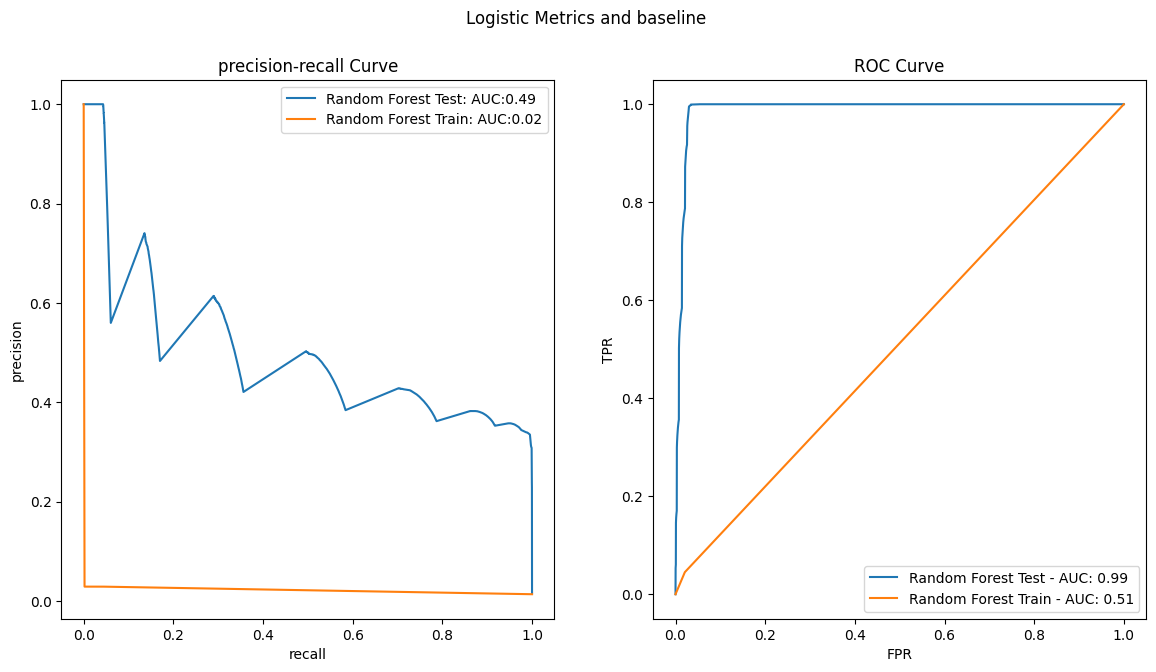

In [ ]:
y_predict_train_probla_randomforest = randomforest_model_dataset_normal.predict_proba(
    x_train_all
)[:, 1]
y_predict_test_probla_randomforest = randomforest_model_dataset_normal.predict_proba(
    x_test_all
)[:, 1]

fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Logistic Metrics and baseline")

plot_metrics(
    f"Random Forest Test",
    y_pred=y_predict_train_probla_randomforest,
    y_test=y_train,
    figure=(fig1, ax1),
)
plot_metrics(
    f"Random Forest Train",
    y_pred=y_predict_test_probla_randomforest,
    y_test=y_test,
    figure=(fig1, ax1),
)

evaluate_model(
    name=f"Random Forest",
    model=randomforest_model_dataset_normal,
    x_train=x_train_all,
    y_train=y_train,
    x_test=x_test_all,
    y_test=y_test,
)

Select the columns with greater importance to 3%

In [180]:
feature_importances = pd.DataFrame(x_train_all.columns)
feature_importances["value"] = pd.Series(
    randomforest_model_dataset_normal.feature_importances_
)
feature_importances = (
    feature_importances.sort_values("value", ascending=False)
    .reset_index()
    .drop("index", axis=1)
)
feature_importances[feature_importances.index <= feature_importances.shape[0] / 2]
feature_importances[feature_importances["value"] >= 0.03]

,0,value
0,global_popularity,0.461605
1,ordered_before,0.085578
2,days_since_purchase_product_type,0.079050
3,user_order_seq,0.077974
4,std_days_to_buy_variant_id,0.048749
5,normalised_price,0.040141
6,avg_days_to_buy_variant_id,0.039764
7,discount_pct,0.037935
8,std_days_to_buy_product_type,0.034844


In [ ]:
columns_x_train = [
    "global_popularity",
    "ordered_before",
    "days_since_purchase_variant_id",
    "abandoned_before",
    "days_since_purchase_product_type",
    "std_days_to_buy_product_type",
    "normalised_price",
    "avg_days_to_buy_product_type",
    "set_as_regular",
]

In [187]:
df_ = feature_frame[columns_x_train]
x_train, x_test, x_valid, y_train, y_test, y_valid = slip_data_set(
    df_, feature_frame_numeric["outcome"]
)

comparate dataset: 3 variables vs all dataset

In [199]:
randomforest_model_dataset_three_variable = RandomForestClassifier(
    class_weight="balanced", max_depth=5
)

randomforest_model_dataset_normal = RandomForestClassifier(
    class_weight="balanced", max_depth=5
)

randomforest_model_dataset_three_variable = (
    randomforest_model_dataset_three_variable.fit(x_train_3, y_train)
)
print("randomforest_model_dataset_three_variable... Complete")
randomforest_model_dataset_normal = randomforest_model_dataset_normal.fit(
    x_train, y_train
)
print("randomforest_model_dataset_normal... Complete")

randomforest_model_dataset_three_variable... Complete
randomforest_model_dataset_normal... Complete


RF three variables:
Train_auc:0.835, Train_precision: 0.165, Train_cross:0.493
Test_auc:0.541, Test_precision: 0.032, Test_cross:0.581
RF normal variables:
Train_auc:0.837, Train_precision: 0.145, Train_cross:0.502
Test_auc:0.591, Test_precision: 0.027, Test_cross:0.734


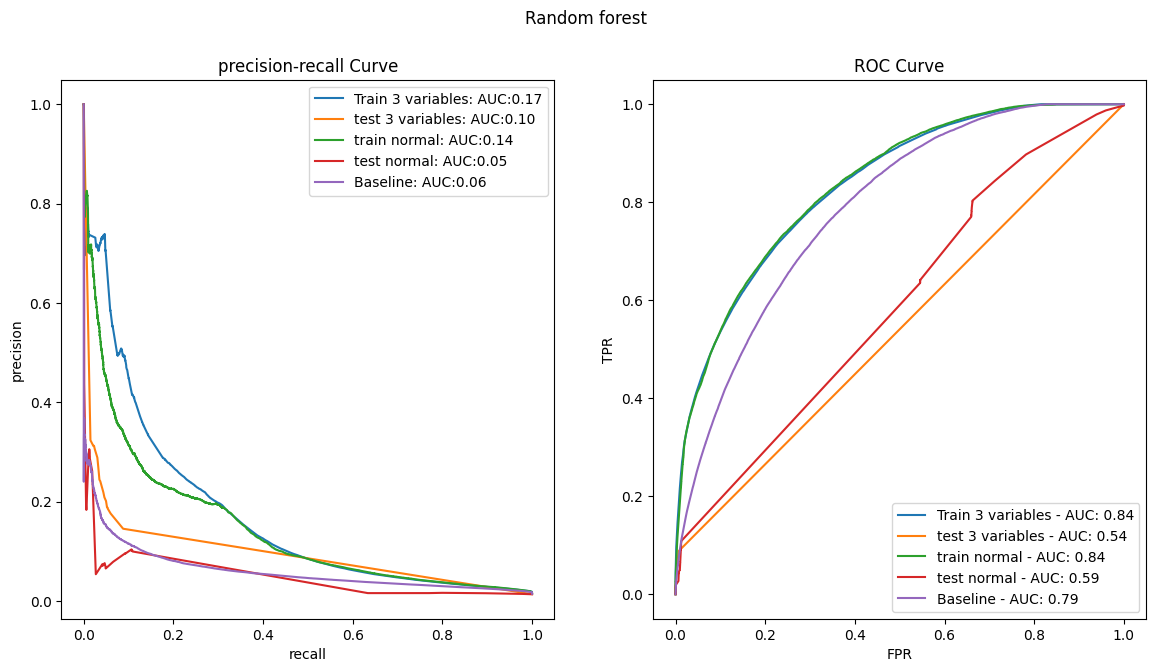

In [200]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Random forest")


y_train_randomforest_model_three_variable = (
    randomforest_model_dataset_three_variable.predict_proba(x_train_3)[:, 1]
)
plot_metrics(
    f"Train 3 variables",
    y_pred=y_train_randomforest_model_three_variable,
    y_test=y_train,
    figure=(fig1, ax1),
)

y_test_randomforest_model_three_variable = (
    randomforest_model_dataset_three_variable.predict_proba(x_test_3)[:, 1]
)
plot_metrics(
    f"test 3 variables",
    y_pred=y_test_randomforest_model_three_variable,
    y_test=y_test,
    figure=(fig1, ax1),
)

evaluate_model(
    name=f"RF three variables",
    model=randomforest_model_dataset_three_variable,
    x_train=x_train_3,
    y_train=y_train,
    x_test=x_test_3,
    y_test=y_test,
)

y_train_randomforest_model_normal = randomforest_model_dataset_normal.predict_proba(
    x_train
)[:, 1]
plot_metrics(
    f"train normal",
    y_pred=y_train_randomforest_model_normal,
    y_test=y_train,
    figure=(fig1, ax1),
)

y_test_randomforest_model_normal = randomforest_model_dataset_normal.predict_proba(
    x_test
)[:, 1]
plot_metrics(
    f"test normal",
    y_pred=y_test_randomforest_model_normal,
    y_test=y_test,
    figure=(fig1, ax1),
)

evaluate_model(
    name=f"RF normal variables",
    model=randomforest_model_dataset_normal,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
)

plot_metrics(
    f"Baseline",
    y_pred=feature_frame["global_popularity"],
    y_test=feature_frame["outcome"],
    figure=(fig1, ax1),
)

with the best dataset, I tested with the number of trees 

RF #5:
Train_auc:0.835, Train_cross:0.496, train_precision: 0.166
Test_auc:0.599, Test_cross:0.593, test_precision: 0.037
RF #10:
Train_auc:0.835, Train_cross:0.492, train_precision: 0.154
Test_auc:0.517, Test_cross:0.589, test_precision: 0.023
RF #100:
Train_auc:0.835, Train_cross:0.493, train_precision: 0.170
Test_auc:0.733, Test_cross:0.592, test_precision: 0.046


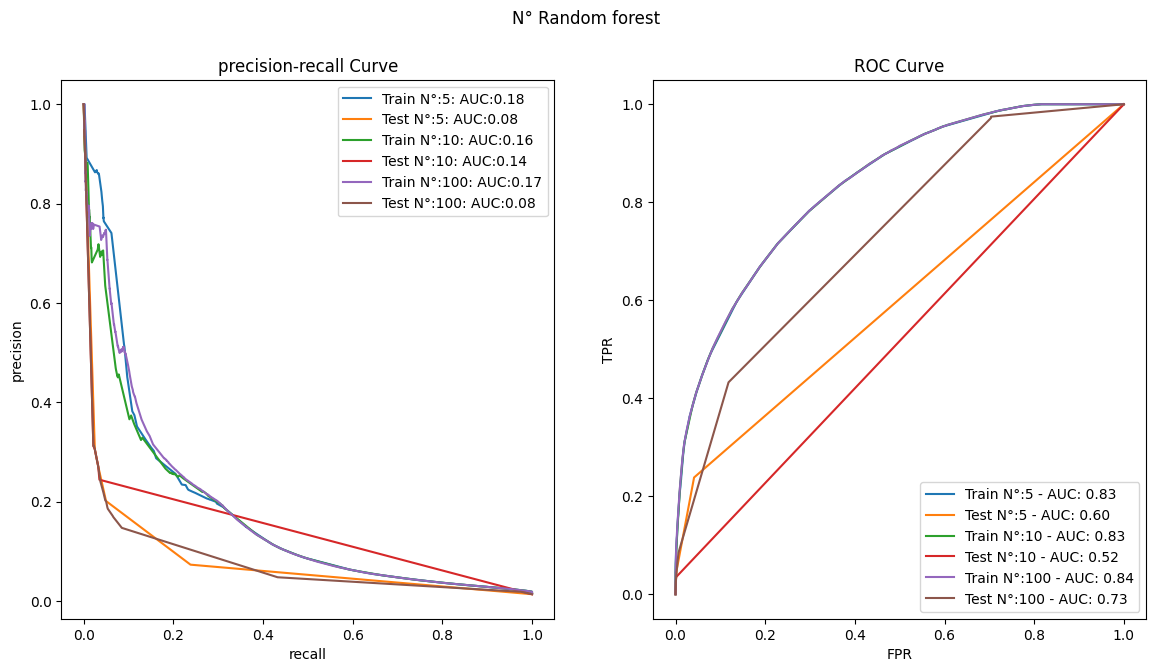

In [ ]:
n_trees = [5, 10, 100]
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("N° Random forest")
figure = (fig1, ax1)
for n_tree in n_trees:

    randomforest_model_3_variable = RandomForestClassifier(
        n_estimators=n_tree,
        class_weight="balanced",
        max_depth=5,
    )

    randomforest_model_3_variable.fit(x_train_3, y_train)

    y_predict_probla_randomforest = randomforest_model_3_variable.predict_proba(
        x_train_3
    )[:, 1]

    plot_metrics(
        f"Train N°:{n_tree}",
        y_pred=y_predict_probla_randomforest,
        y_test=y_train,
        figure=(fig1, ax1),
    )

    y_predict_probla_randomforest = randomforest_model_3_variable.predict_proba(
        x_test_3
    )[:, 1]

    plot_metrics(
        f"Test N°:{n_tree}",
        y_pred=y_predict_probla_randomforest,
        y_test=y_test,
        figure=(fig1, ax1),
    )

    evaluate_model(
        name=f"RF #{n_tree}",
        model=randomforest_model_3_variable,
        x_train=x_train_3,
        y_train=y_train,
        x_test=x_test_3,
        y_test=y_test,
    )

In this case, the best model was the ten tree model with the 3-variable dataset. Showing better performance than its baseline counterpart.

In [130]:
randomforest_model_3_variable = RandomForestClassifier(
    n_estimators=10,
    class_weight="balanced",
    max_depth=5,
)

randomforest_model_3_variable.fit(x_train_3, y_train)

y_predict_probla_randomforest = randomforest_model_3_variable.predict_proba(x_test_3)[
    :, 1
]

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=10)

## Gradient Boosting Trees

Try with the dataset 3 variable

In [150]:
gbt_model = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.05, max_depth=5
)

gbt_model.fit(x_train_3, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5)

Gbt_model:
Train_auc:0.835, Train_precision: 0.172, Train_cross:0.064
Test_auc:0.525, Test_precision: 0.027, Test_cross:0.071


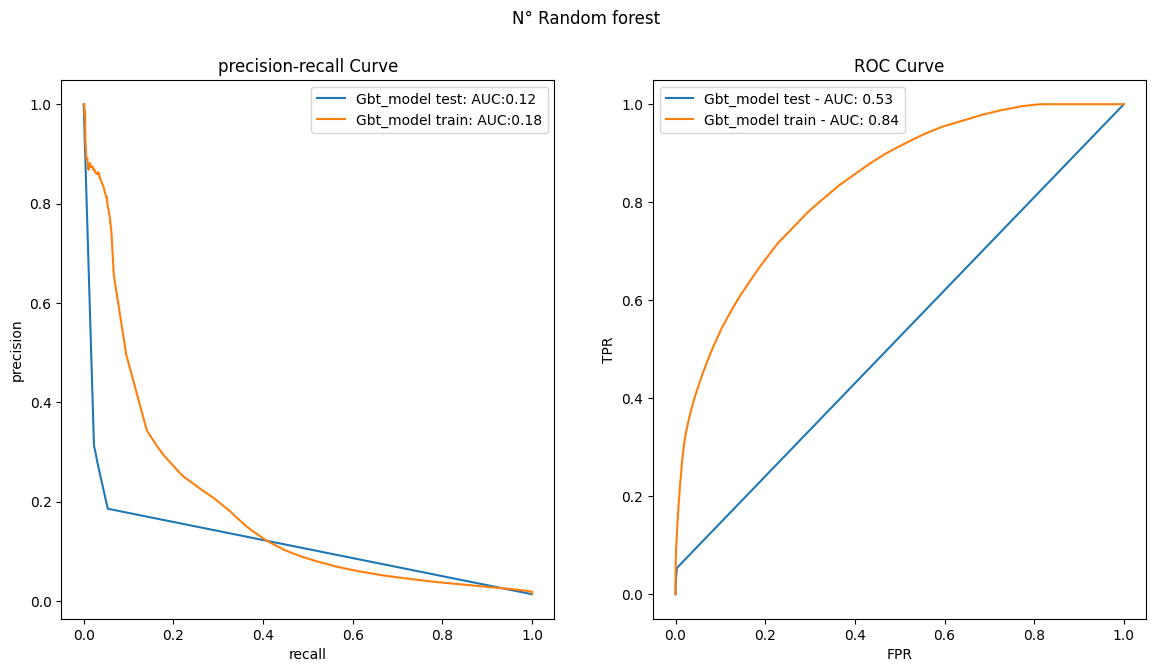

In [212]:
n_trees = [5, 10, 100]
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("N° Random forest")


evaluate_model(
    name=f"Gbt_model",
    model=gbt_model,
    x_train=x_train_3,
    y_train=y_train,
    x_test=x_test_3,
    y_test=y_test,
)

y_predict_probla_Gbt_model = gbt_model.predict_proba(x_test_3)[:, 1]
y_predict_train_probla_Gbt_model = gbt_model.predict_proba(x_train_3)[:, 1]

plot_metrics(
    f"Gbt_model test",
    y_pred=y_predict_probla_Gbt_model,
    y_test=y_test,
    figure=(fig1, ax1),
)
plot_metrics(
    f"Gbt_model train",
    y_pred=y_predict_train_probla_Gbt_model,
    y_test=y_train,
    figure=(fig1, ax1),
)

I tried varying the learning rate and depth

LGB 0.05, Depht: 2:
Train_auc:0.647, Train_precision: 0.131, Train_cross:0.070
Test_auc:0.500, Test_precision: 0.014, Test_cross:0.072
LGB 0.05, Depht: 3:
Train_auc:0.807, Train_precision: 0.159, Train_cross:0.067
Test_auc:0.516, Test_precision: 0.023, Test_cross:0.072
LGB 0.05, Depht: 5:
Train_auc:0.835, Train_precision: 0.172, Train_cross:0.067
Test_auc:0.525, Test_precision: 0.027, Test_cross:0.071
LGB 0.1, Depht: 2:
Train_auc:0.819, Train_precision: 0.147, Train_cross:0.065
Test_auc:0.516, Test_precision: 0.023, Test_cross:0.072
LGB 0.1, Depht: 3:
Train_auc:0.834, Train_precision: 0.162, Train_cross:0.064
Test_auc:0.525, Test_precision: 0.026, Test_cross:0.071
LGB 0.1, Depht: 5:
Train_auc:0.835, Train_precision: 0.172, Train_cross:0.064
Test_auc:0.525, Test_precision: 0.027, Test_cross:0.071


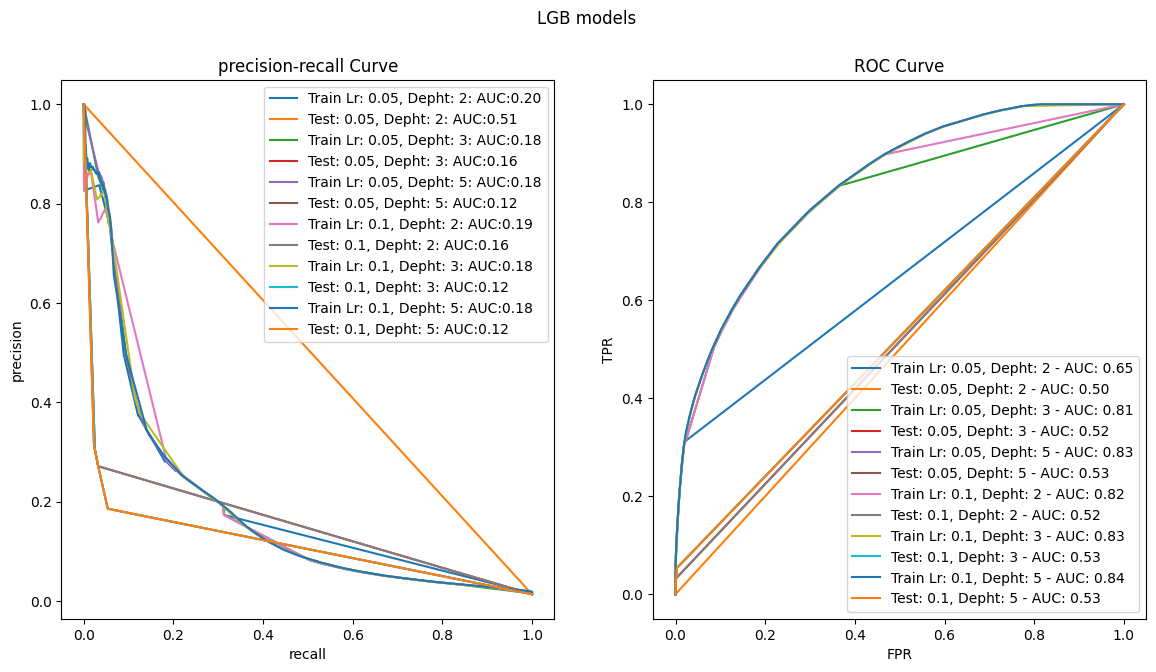

In [201]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("LGB models")

for learning_rate in [0.05, 0.1]:
    for depth in [2, 3, 5]:
        gbt_model = GradientBoostingClassifier(
            n_estimators=10, learning_rate=learning_rate, max_depth=depth
        )
        gbt_model.fit(x_train_3, y_train)

        y_train_gbt_model_predict = gbt_model.predict_proba(x_train_3)[:, 1]

        plot_metrics(
            f"Train Lr: {learning_rate}, Depht: {depth}",
            y_pred=y_train_gbt_model_predict,
            y_test=y_train,
            figure=(fig1, ax1),
        )

        y_test_gbt_model_predict = gbt_model.predict_proba(x_test_3)[:, 1]

        plot_metrics(
            f"Test: {learning_rate}, Depht: {depth}",
            y_pred=y_test_gbt_model_predict,
            y_test=y_test,
            figure=(fig1, ax1),
        )

        evaluate_model(
            name=f"LGB {learning_rate}, Depht: {depth}",
            model=gbt_model,
            x_train=x_train_3,
            y_train=y_train,
            x_test=x_test_3,
            y_test=y_test,
        )

The best model was 0.05 learning rate and 5 depth of tree
Next try reducing the learning rate 

Train Lr: 0.1, Depht: 7:
Train_auc:0.830, Train_precision: 0.157, Train_cross:0.078
Test_auc:0.516, Test_precision: 0.022, Test_cross:0.072


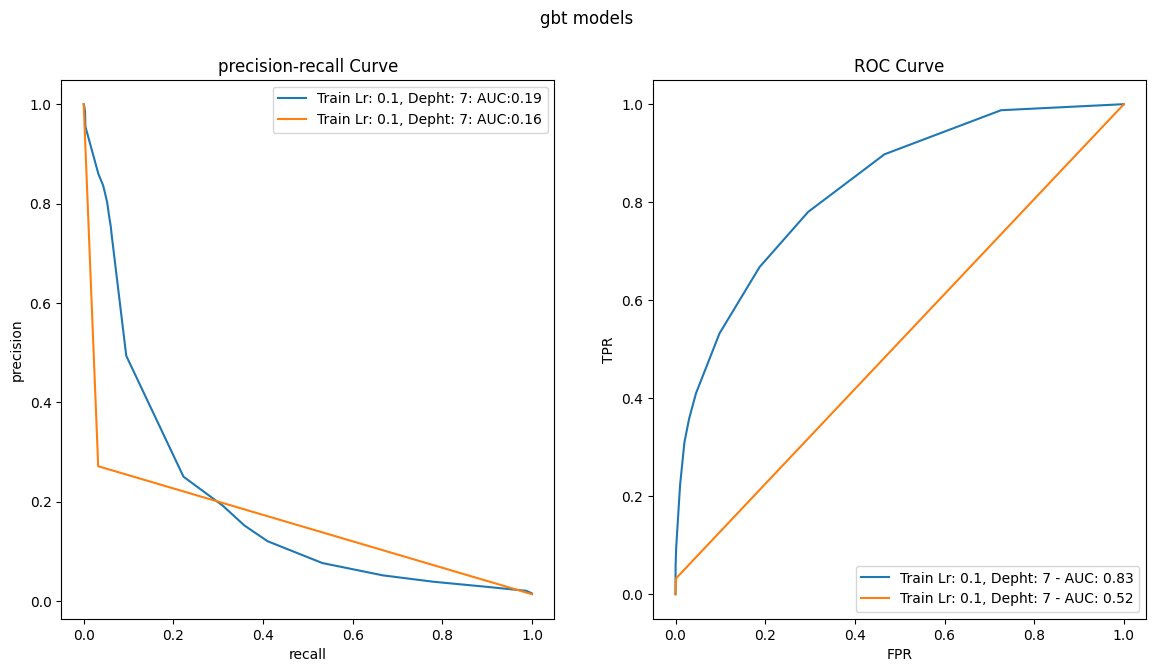

In [ ]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("gbt models")

gbt_model = GradientBoostingClassifier(n_estimators=10, learning_rate=0.01, max_depth=5)
gbt_model.fit(x_train_3, y_train)

y_train_gbt_model_predict = gbt_model.predict_proba(x_train_3)[:, 1]

plot_metrics(
    f"Train Lr: 0.1, Depht: 5",
    y_pred=y_train_gbt_model_predict,
    y_test=y_train,
    figure=(fig1, ax1),
)

y_test_gbt_model_predict = gbt_model.predict_proba(x_test_3)[:, 1]

plot_metrics(
    f"Train Lr: 0.1, Depht: 5",
    y_pred=y_test_gbt_model_predict,
    y_test=y_test,
    figure=(fig1, ax1),
)

evaluate_model(
    name=f"Train Lr: 0.1, Depht: 7",
    model=gbt_model,
    x_train=x_train_3,
    y_train=y_train,
    x_test=x_test_3,
    y_test=y_test,
)

## Comparation models

In [219]:
models = {
    "LogReg_model_rigde_f": LogReg_model_rigde_f,
    "randomforest_model_3_variable": randomforest_model_3_variable,
    "gbt_model": gbt_model,
}
y_predicts_test = []
for model in models:
    y_predicts_test.append(models[model].predict_proba(x_test_3)[:, 1])

LogReg_model_rigde_f:
Train_auc:0.833, Train_precision: 0.156, Train_cross:0.067
Test_auc:0.834, Test_precision: 0.155, Test_cross:0.070
randomforest_model_3_variable:
Train_auc:0.835, Train_precision: 0.168, Train_cross:0.491
Test_auc:0.525, Test_precision: 0.026, Test_cross:0.561
gbt_model:
Train_auc:0.830, Train_precision: 0.157, Train_cross:0.078
Test_auc:0.516, Test_precision: 0.022, Test_cross:0.072


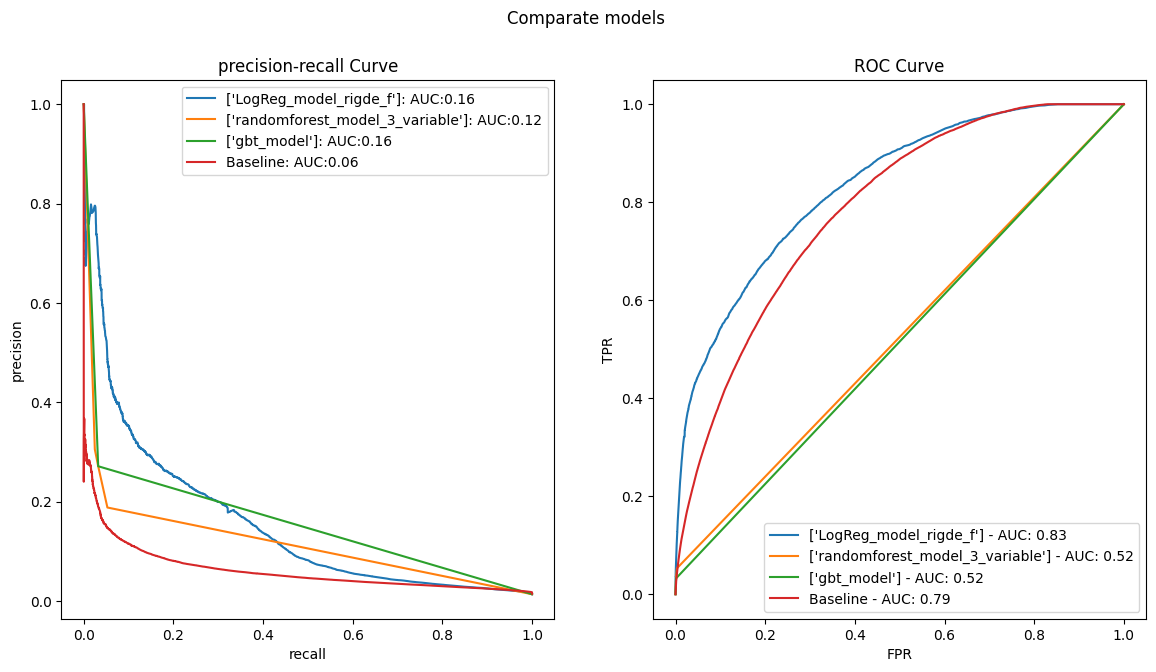

In [220]:
n_trees = [5, 10, 100]
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Comparate models")

for i, item in enumerate(models.items()):
    plot_metrics(
        f"{[item[0]]}", y_pred=y_predicts_test[i], y_test=y_test, figure=(fig1, ax1)
    )
    evaluate_model(
        name=f"{item[0]}",
        model=item[1],
        x_train=x_train_3,
        y_train=y_train,
        x_test=x_test_3,
        y_test=y_test,
    )
plot_metrics(
    f"Baseline",
    y_pred=feature_frame["global_popularity"],
    y_test=feature_frame["outcome"],
    figure=(fig1, ax1),
)

The logistic regression with Ridge regularization was the best model in this case for recall values in the range of 0.1 to 0.3, achieving an AUC of 0.16 in the precision-recall curve.

Different versions of the dataset were tested: the complete numerical dataset, the dataset with only coefficients higher than 0.03, and the dataset with the three most important variables. In all models, the best performance was obtained using the three most important variables. Ironically, this was also true for the tree-based models, but no adjustments improved their performance significantly.

All models outperformed the baseline, confirming their predictive value. Logistic regression remains the best option in this case. Perhaps the tree-based models require deeper hyperparameter tuning, or the relationship between the variables is more linear, which favors regression.

In [ ]:
joblib.dump(LogReg_model_rigde_f, "modelo_push_notifications_1.pkl")